# <span style="color:blue">Trabalho Final - Classificação de Revisão de Filmes</span>

## <span style="color:blue">Trabalho Final - Notebook </span>

**Grupo:**<br>
>**Augusto Santos Bettin**<br>
>**Cleber Jose Campos Martins**<br>
>**Jéssica Copel Rothman**<br>
>**Pedro Mesquita Moura**<br>
>**Vinicius Tessele**<br>
>**Winardlley Nardson Lima**<br>

**Mineração de Dados Complexos - 2018/2 - Campinas/UNICAMP**

Este *notebook* contém o código para as tarefas propostas no enunciado do trabalho.

### Análise da base de dados critic (classificação binária)

### Bibliotecas necessárias

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Função Auxiliar para aplicação de pesos

In [40]:
# Função para aplicar pesos no DataFrame
def apply_class_weights(df, target_column, weights):
    balanced_data = []
    for label, weight in weights.items():
        class_data = df[df[target_column] == label]
        balanced_data.append(class_data.sample(frac=weight, replace=True, random_state=42))
    return pd.concat(balanced_data).sample(frac=1, random_state=42)

### 1. Carregando a base de dados

In [41]:
# 1. Carregar a base de dados de treinamento
df_train = pd.read_csv('train_critic.csv')

### 2. Verificando o desbalanceamento

In [42]:
# 2. Verificar desbalanceamento da classe 'Sentiment'
print("Distribuição das classes 'Sentiment' (original):")
print(df_train['Sentiment'].value_counts())

Distribuição das classes 'Sentiment' (original):
Sentiment
1    9995
0    1837
Name: count, dtype: int64


### 3. Tratamento dos dados

In [43]:
# 3. Tratar valores ausentes no conjunto original
df_train = df_train.dropna(subset=['Review'])

### 4. Divisão do train_critic.csv em treino 80% e validação 20%

In [44]:
# 4. Dividir a base de treino em 80% treino e 20% validação
X = df_train['Review']
y = df_train['Sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir a distribuição antes do balanceamento
print("\nDistribuição da classe 'Sentiment' no conjunto de treino (antes do balanceamento):")
print(y_train.value_counts())


Distribuição da classe 'Sentiment' no conjunto de treino (antes do balanceamento):
Sentiment
1    7992
0    1472
Name: count, dtype: int64


### 5. Calcular pesos para o metódo por ponderamento de pesos

In [45]:
# 5. Calcular os pesos das classes com base no conjunto de treino
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("\nPesos das classes (treino):", class_weight_dict)


Pesos das classes (treino): {0: 3.214673913043478, 1: 0.5920920920920921}


### 6. Aplicando pesos no conjunto de treino

In [46]:
# 6. Aplicar os pesos apenas no conjunto de treino
train_data = pd.DataFrame({'Review': X_train, 'Sentiment': y_train})
train_data_balanced = apply_class_weights(train_data, 'Sentiment', class_weight_dict)

# Exibir a distribuição após o balanceamento
print("\nDistribuição da classe 'Sentiment' no conjunto de treino (após o balanceamento):")
print(train_data_balanced['Sentiment'].value_counts())

X_train_balanced = train_data_balanced['Review']
y_train_balanced = train_data_balanced['Sentiment']


Distribuição da classe 'Sentiment' no conjunto de treino (após o balanceamento):
Sentiment
0    4732
1    4732
Name: count, dtype: int64


### 7. Gerando o modelo

In [47]:
# 7. Criar um pipeline com TfidfVectorizer e SVM com o kernel linear
pipeline_svm = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=4015),  # TfidfVectorizer com no máximo 4015 palavras
    SVC(kernel='linear', class_weight='balanced')  # SVM com pesos embutidos
)

### 8. Treinando o modelo

In [48]:
# 8. Treinar o modelo com o conjunto de treino balanceado
pipeline_svm.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=4015, stop_words='english')),
                ('svc', SVC(class_weight='balanced', kernel='linear'))])

### 9. Predições no conjunto de validação

In [49]:
# 9. Predições no conjunto de validação
y_val_pred = pipeline_svm.predict(X_val)

### 10. Matriz de Confusão e Acurácia Balanceada no conjunto de validação


Matriz de Confusão (Validação):
[[ 227  137]
 [ 399 1604]]
Acurácia Balanceada (Validação): 0.7122


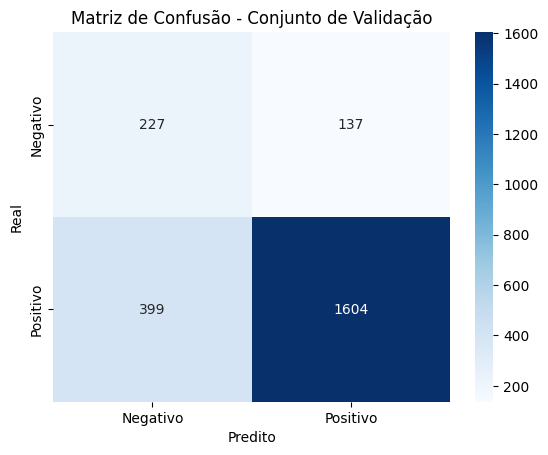

In [50]:
# 10. Avaliação no conjunto de validação
cm_val = confusion_matrix(y_val, y_val_pred)
balanced_accuracy_val = balanced_accuracy_score(y_val, y_val_pred)

print("\nMatriz de Confusão (Validação):")
print(cm_val)
print(f"Acurácia Balanceada (Validação): {balanced_accuracy_val:.4f}")

# Plotar a matriz de confusão para o conjunto de validação
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title("Matriz de Confusão - Conjunto de Validação")
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

### 11. Carregando conjunto de teste

In [51]:
# 11. Carregar o conjunto de teste
df_test = pd.read_csv('test_critic.csv')

### 12. Tratamento de dados no conjunto de teste

In [52]:
# 12. Tratar valores ausentes no conjunto de teste
df_test = df_test.dropna(subset=['Review'])

X_test = df_test['Review']
y_test = df_test['Sentiment']

### 13. Predições no conjunto de teste

In [53]:
# 13. Predições no conjunto de teste
y_test_pred = pipeline_svm.predict(X_test)

### 14. Matriz de Confusão e Acurácia Balanceada no conjunto de teste


Matriz de Confusão (Teste):
[[ 252  197]
 [ 533 1977]]
Acurácia Balanceada (Teste): 0.6744


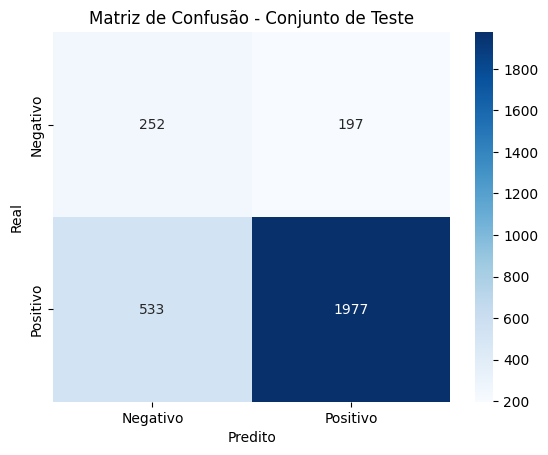

In [54]:
# 14. Avaliação no conjunto de teste
cm_test = confusion_matrix(y_test, y_test_pred)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)

print("\nMatriz de Confusão (Teste):")
print(cm_test)
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_test:.4f}")

# Plotar a matriz de confusão para o conjunto de teste
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title("Matriz de Confusão - Conjunto de Teste")
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()